In [28]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

In [29]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array(nino34['nino34'].values)

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


In [30]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [31]:
oni = ONI(nino34)

In [32]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [33]:
clm = climatology(nino34)

In [34]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [35]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

# Data Preparation

In [36]:
T = 6                       # prediction timeline
H = 48                      # history used for prediction
include_month = 1           # 1 if we use the month as a feature, 0 otherwise
n_classes = 3               # number of classes (El Nino, El Nina, No Event)
threshold = 0.5         
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points
size = length - H - T       # effective dataset size

In [37]:
# create the 'history matrix'
data = np.ndarray((size, H + include_month))
for i in range(size):
    if(include_month == False):
        data[i] = signal[i:(i + H)]
    else:
        data[i] = np.append(signal[i:(i + H)], (i + H + T) % 12)

# label El Nino as 2, El Nina as 0 and no event as 1
labels = np.ndarray((size))
for i in range(length - H - T):
    if(oanm[i + H + T] >= threshold):
        labels[i] = 2
    elif(oanm[i + H + T] <= -threshold):
        labels[i] = 0
    else:
        labels[i] = 1

In [38]:
np.random.seed(0)

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[(8 * split + 1): 9 * split])
test_ind = np.array(shuffle[(9 * split + 1): size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

# Normalization and Label One-Hot Encoding

We normalize each feature individually because of the difference in scale between month number and temperature values.

In [39]:
mean = np.mean(train, axis = 0)
std = np.std(train, axis = 0)

train_n = np.divide(
    train - np.outer(np.ones(train.shape[0]), mean),
    np.outer(np.ones(train.shape[0]), std))

val_n = np.divide(
    val - np.outer(np.ones(val.shape[0]), mean),
    np.outer(np.ones(val.shape[0]), std))

test_n = np.divide(
    test - np.outer(np.ones(test.shape[0]), mean),
    np.outer(np.ones(test.shape[0]), std))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    encoded_train_labels = tf.one_hot(train_labels, depth = n_classes).eval()
    encoded_val_labels = tf.one_hot(val_labels, depth = n_classes).eval()
    encoded_test_labels = tf.one_hot(test_labels, depth = n_classes).eval()

# Training Network using the month feature

We will use the augmented data with the best architectures chosen in Part III.

In [35]:
for m in best_models:
    (d, N1, N2, N3) = m
    model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(N1, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N2, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(N3, activation=tf.nn.relu),
              tf.keras.layers.Dropout(d),
              tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
            ])

    model.reset_states()

    model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)
    (loss_m[(d, N1, N2, N3)], acc_m[(d, N1, N2, N3)]) = model.evaluate(val_n, encoded_val_labels, verbose = 0)
    print(d, N1, N2, N3, "=>", acc_m[(d, N1, N2, N3)])

0.3 192 768 1536 => 0.7619663649666356
0.2 384 768 384 => 0.7296248383309215
0.5 384 768 384 => 0.7373868047342881
0.3 384 768 768 => 0.7399741269330004
0.5 768 384 768 => 0.7438551100382984
0.2 768 384 1536 => 0.756791720607765
0.5 768 384 1536 => 0.7477360932207046
0.3 768 768 384 => 0.7632600259503294
0.2 768 1536 768 => 0.738680465756536
0.5 768 1536 768 => 0.7283311772701194
0.2 1536 384 384 => 0.7076326004129486
0.5 1536 768 192 => 0.7166882277229008
0.3 1536 768 384 => 0.7218628720046631
0.3 1536 768 768 => 0.7309184995073859
0.3 1536 768 1536 => 0.7477360932978128
0.5 1536 1536 384 => 0.7115135834796925


# Success per month

In [41]:
epochs = 60

In [42]:
(d, N1, N2, N3) = (0.3, 768, 768, 384)
model = tf.keras.models.Sequential([
          tf.keras.layers.Dense(N1, activation=tf.nn.relu),
          tf.keras.layers.Dropout(d),
          tf.keras.layers.Dense(N2, activation=tf.nn.relu),
          tf.keras.layers.Dropout(d),
          tf.keras.layers.Dense(N3, activation=tf.nn.relu),
          tf.keras.layers.Dropout(d),
          tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax)
        ])

model.reset_states()

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.fit(train_n, encoded_train_labels, epochs = epochs, verbose = 0)

IndexError: arrays used as indices must be of integer (or boolean) type

0.734375
0.765625
0.71875
0.703125
0.671875
0.703125
0.6875
0.734375
0.671875
0.671875
0.65625
0.734375


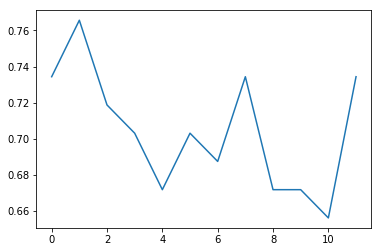

In [44]:
length = encoded_val_labels.shape[0]
loss_m = np.zeros(12)
acc_m = np.zeros(12)

for m in range(12):
    selection = 12 * np.arange(length // 12) + m * np.ones((length // 12), dtype = int)
    (loss_m[m], acc_m[m]) = model.evaluate(val_n[selection], encoded_val_labels[selection], verbose = 0)
    print(acc_m[m])
    
plt.plot(acc_m);